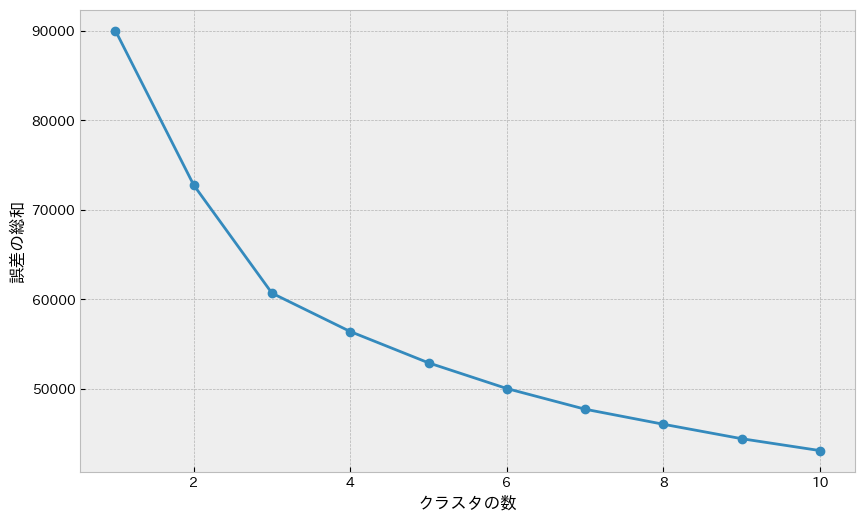

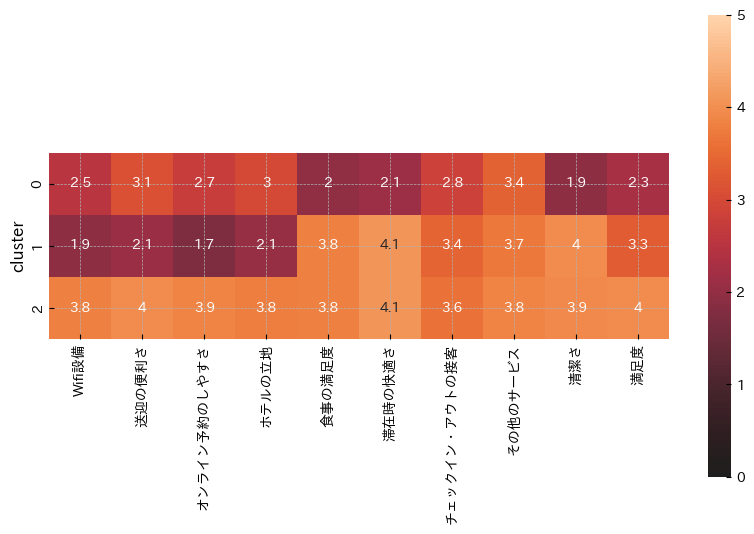

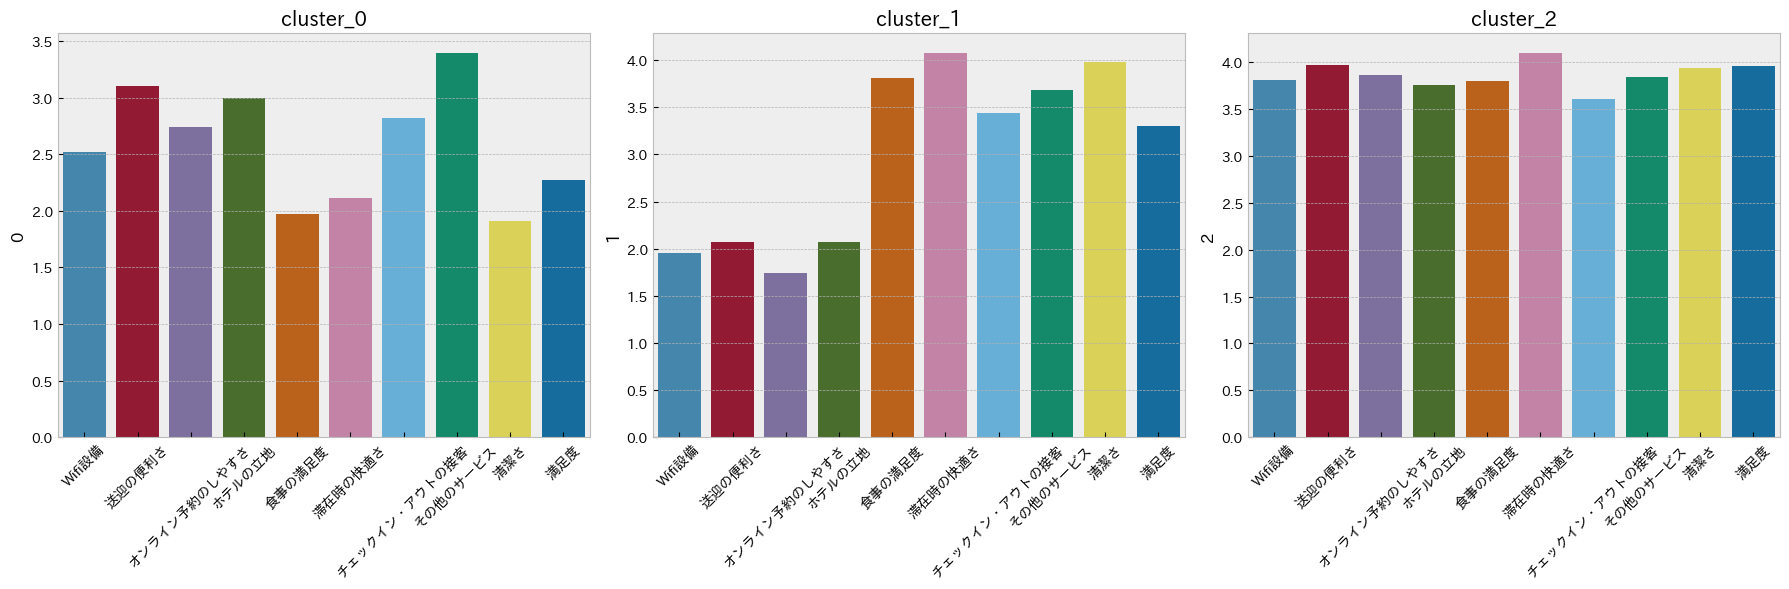

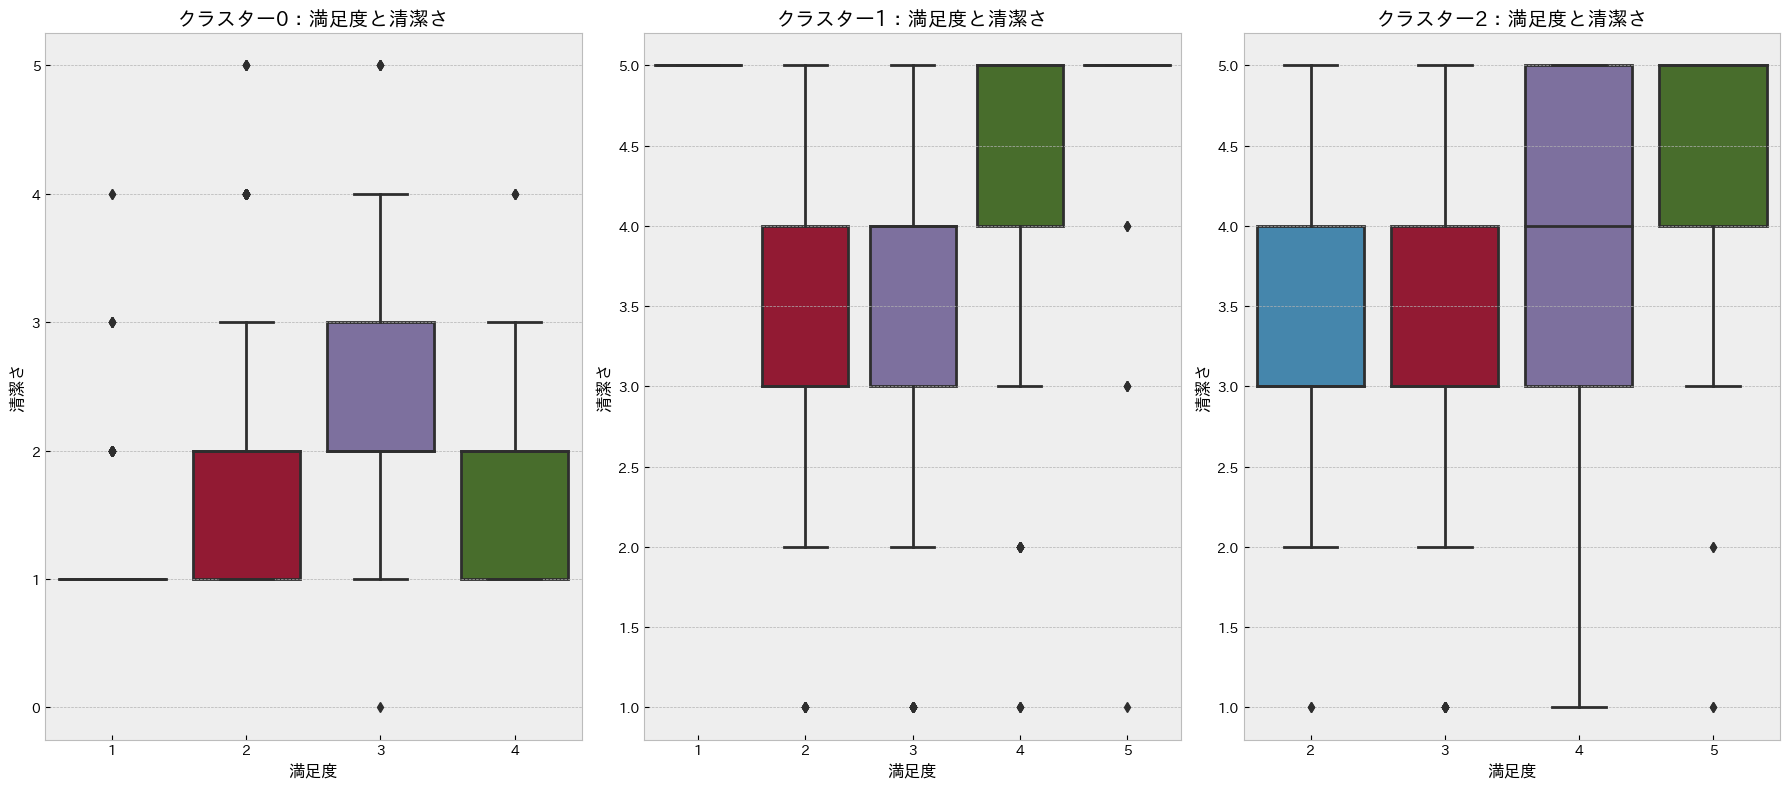

In [13]:
"""
データ分析　演習問題4

目的：クラスタリングを用いて、グループごとのにホテルの満足度に影響を与える要因を分析する
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from scipy import stats
import warnings

import statsmodels.api as sm

warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh') # matplotlib のスタイルの設定

plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv('../../data/dummy_data/hotel_reviews.csv')

# 数値だけのDataFrameに
df_numeric = df.select_dtypes(include='number')

# 年齢の相関を確認
df_numeric.corr()['年齢']

# 年齢と満足度を除外
_df = df_numeric.drop(['年齢', '満足度'], axis=1)

# クラスタリング

# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(_df)

# NOTE: SSE: Sum of Squared Errors(残差平方和)
# NOTE: inertia_: クラスタリングの結果のSSE

from sklearn.cluster import KMeans

# エルボー法でクラスタの数を決定（残差平方和を求める）
sse = []

for i  in range(1,11):                
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(x_scaled)             
    sse.append(kmeans.inertia_)   # kmeans.fitするとkmeans.inertia_が得られる
    
# 可視化
plt.plot(range(1,11), sse , marker='o')
plt.xlabel('クラスタの数') 
plt.ylabel('誤差の総和')
plt.show()

# ３で決定してクラスタリング
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(x_scaled)

cluster = kmeans.labels_

df['cluster'] = cluster

# クラスタごとにグループ化
groups = df.groupby('cluster')

# クラスタごとのデータ数
groups.size()

# 代表値を確認
groups.agg(['min', 'max', 'mean', 'median'])

mean = groups.mean().drop('年齢', axis=1)

sns.heatmap(mean, annot=True, square=True, vmax=5, center=0, vmin=0)

# クラスタ数
num = kmeans.n_clusters

# クラスターごとに可視化
# NOTE: 解釈の例
#   クラスタ０：評価が低めグループ
#   クラスタ１：評価が低めのグループ
#   クラスタ２：すべての評価が高いグループ
plt.figure(figsize=(18, 6))


for n in range(num):
    plt.subplot(1, 3, n+1)
    plt.title(f'cluster_{n}')
    sns.barplot(x=mean.columns, y=mean.loc[n])
    plt.xticks(rotation=45) # 凡例を 45 ℃ 傾けて表示
    plt.tight_layout() 
    
# 各変数ごとに可視化して確認
plt.figure(figsize=(18, 8))

for i, col in enumerate(mean.columns):
    plt.subplot(2, 5, i+1)
    plt.title(f'{col}')
    sns.barplot(x=mean.index, y=mean[col])
    plt.tight_layout()
    
# クラスタごとのデータを取得
cluster0 = groups.get_group(0)
cluster0 = cluster0.reset_index(drop=True)
cluster1 = groups.get_group(1)
cluster1 = cluster1.reset_index(drop=True)
cluster2 = groups.get_group(2)
cluster2 = cluster2.reset_index(drop=True)

# 箱ひげ図で可視化

def box_plot(col1, col2, dflist, high=6, width=18):
    """箱ひげ図で可視化する関数"""
    plt.rcParams['figure.figsize'] = width, high

    for i, cluster in enumerate(dflist):
        plt.subplot(1, len(dflist), i+1)
        plt.title(f'クラスター{i}：{col1}と{col2}')
        sns.boxplot(x=col1, y=col2, data=cluster)
        plt.tight_layout()


# 箱ひげ図で可視化

df_list = [cluster0, cluster1, cluster2]

# クラスタごとの満足度と各変数の関係を確認

# box_plot('満足度', 'Wifi設備', df_list)
# box_plot('満足度', '送迎の便利さ', df_list)
# box_plot('満足度', 'オンライン予約のしやすさ', df_list)
# box_plot('満足度', '送迎の便利さ', df_list)
# box_plot('満足度', '食事の満足度', df_list)
# box_plot('満足度', '滞在時の快適さ', df_list)
# box_plot('満足度', '清潔さ', df_list)
